# $Z_3$ model for baryon physics

In [48]:
import numpy as np
import scipy
omega = np.exp(2j*np.pi/3)
V = np.array([[1,0,0],[0,omega,0],[0,0,omega**2]])
U = np.array([[0,1,0],[0,0,1],[1,0,0]])

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Building dense and sparse Kronecker-construction functions for placing a 3x3 operator V on a chosen site (or sites)
# in a chain of N sites (local dimension 3). 
# The operator space dimension is 3**N.
# Dense version uses numpy.kron, sparse version uses scipy.sparse.kron.
# Site indexing: 0-based (0 .. N-1). You can pass a single int or a list/tuple of ints for `sites`.
# The functions validate V shape and the sites list.
# Example usage demonstrated at the end.

import numpy as np

def kron_dense(factors):
    """Helper: compute Kronecker product of a list of dense arrays (left-to-right)."""
    from functools import reduce
    return reduce(np.kron, factors)

def op_on_sites_dense(V, N, sites):
    """
    Construct dense operator on (C^3)^{\otimes N} with operator V placed on the given `sites`.
    Parameters
    ----------
    V : array-like, shape (3,3)
        Local operator to place.
    N : int
        Number of sites (N >= 1).
    sites : int or sequence of ints
        Site index or list of site indices (0-based) where V is placed.
    Returns
    -------
    O : ndarray, shape (3**N, 3**N)
        The dense operator.
    """
    if V.shape != (3,3):
        raise ValueError("V must be a 3x3 matrix.")
    if N < 1 or int(N) != N:
        raise ValueError("N must be a positive integer.")
    if isinstance(sites, int):
        sites = [sites]
    sites = sorted(int(s) for s in sites)
    if any(s < 0 or s >= N for s in sites):
        raise IndexError("Site indices must be in range 0..N-1.")
    
    I3 = np.eye(3, dtype=V.dtype)
    factors = [(V if i in sites else I3) for i in range(N)]
    return kron_dense(factors)


# Sparse version
def op_on_sites_sparse(V, N, sites, format='csr'):
    """
    Construct sparse operator on (C^3)^{\otimes N} with operator V placed on the given `sites`.
    Returns a scipy.sparse matrix (by default CSR).
    """
    import scipy.sparse as sp

    V = sp.csr_matrix(V) if not sp.issparse(V) else V.tocsr()
    if V.shape != (3,3):
        raise ValueError("V must be a 3x3 matrix or sparse 3x3.")
    if N < 1 or int(N) != N:
        raise ValueError("N must be a positive integer.")
    if isinstance(sites, int):
        sites = [sites]
    sites = sorted(int(s) for s in sites)
    if any(s < 0 or s >= N for s in sites):
        raise IndexError("Site indices must be in range 0..N-1.")

    I3 = sp.eye(3, format='csr', dtype=V.dtype)
    result = None
    # left-to-right Kronecker (site 0 is the leftmost factor)
    for i in range(N):
        factor = V if i in sites else I3
        if result is None:
            result = factor
        else:
            result = sp.kron(result, factor, format='csr')
    if format != 'csr':
        result = result.asformat(format)
    return result

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:49: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:49: SyntaxWarning: invalid escape sequence '\o'
C:\Users\HP\AppData\Local\Temp\ipykernel_460\3085680282.py:17: SyntaxWarning: invalid escape sequence '\o'
  """
C:\Users\HP\AppData\Local\Temp\ipykernel_460\3085680282.py:49: SyntaxWarning: invalid escape sequence '\o'
  """


In [143]:
from qs_mps.lattice import Lattice
from scipy.sparse import identity, csr_array

class H_Z3_gauss:
    def __init__(
        self,
        Lx,
        Ly,
        model: str,
        lamb: float = 0,
        J: float = 1,
        G: float = 1e3,
        pbc: bool = True,
    ):
        self.Lx = Lx
        self.Ly = Ly
        self.model = model
        self.pbc = pbc
        self.charges = np.ones((Ly+1*(1 - pbc), Lx+1), dtype=np.complex128)
        self.lamb = lamb
        self.J = J
        self.G = G
        self.latt = Lattice((self.Lx+1, self.Ly+1*(1 - pbc)), (False, pbc))
        self.dof = self.latt.nlinks
        self.sector = self._define_sector()

    def add_charges(self, rows: list, columns: list, vals: list):
        """
        add_charges

        This function adds the charges to the background
        vacuum sector (all positive charges). The number of
        charges we add are given by the len of each indices list

        rows: list - row indices of the charges to add
        columns: list - column indices of the charges to add
        """
        for i, j, q in zip(rows, columns, vals):
            self.charges[j, i] = q

        # self.charges = np.flip(self.charges, axis=0)
        return self

    def _define_sector(self):
        particles = 0
        for charge in self.charges.flatten():
            if charge != 1:
                particles += 1

        if particles == 0:
            sector = "vacuum_sector"
        else:
            sector = f"{particles}_particle(s)_sector"
            self.sector = sector
        return sector

    def local_term(self, link):
        sigma_x = op_on_sites_sparse(V, sites=link, N=self.latt.nlinks)
        return sigma_x

    def plaquette_term(self, loop):
        plaq = op_on_sites_sparse(U, sites=loop[0], N=self.latt.nlinks) @ op_on_sites_sparse(U, sites=loop[1], N=self.latt.nlinks) @ op_on_sites_sparse(U.conjugate().T, sites=loop[2], N=self.latt.nlinks) @ op_on_sites_sparse(U.conjugate().T, sites=loop[3], N=self.latt.nlinks)
        return plaq

    def gauge_constraint(self, site):
        links = self.latt.star(site=site, Lx=self.Lx, Ly=self.Ly)
        G = identity(n=3**self.latt.nlinks)
        filtered_links = [element for element in links if element != 0]
        # print("links:")
        # print(filtered_links)
        for i, link in enumerate(filtered_links):
            if self.pbc:
                if (site[0] < self.Lx):
                    if i > 1:
                        print(site, link, "conjugate")
                        G = G @ op_on_sites_sparse(V.conjugate().T, sites=link - 1, N=self.latt.nlinks)
                    else:
                        print(site, link, "normal")
                        G = G @ op_on_sites_sparse(V, sites=link - 1, N=self.latt.nlinks)
                else:
                    if i > 0:
                        print(site, link, "conjugate")
                        G = G @ op_on_sites_sparse(V.conjugate().T, sites=link - 1, N=self.latt.nlinks)
                    else:
                        print(site, link, "normal")
                        G = G @ op_on_sites_sparse(V, sites=link - 1, N=self.latt.nlinks)
            else:
                if (site[0] < self.Lx) and (site[1] < self.Ly):
                    if i > 1:
                        print(site, link, "conjugate")
                        G = G @ op_on_sites_sparse(V.conjugate().T, sites=link - 1, N=self.latt.nlinks)
                    else:
                        print(site, link, "normal")
                        G = G @ op_on_sites_sparse(V, sites=link - 1, N=self.latt.nlinks)
                elif ((site[0] == self.Lx and site[1] < self.Ly) or (site[0] < self.Lx and site[1] == self.Ly)):
                    if i > 0:
                        print(site, link, "conjugate")
                        G = G @ op_on_sites_sparse(V.conjugate().T, sites=link - 1, N=self.latt.nlinks)
                    else:
                        print(site, link, "normal")
                        G = G @ op_on_sites_sparse(V, sites=link - 1, N=self.latt.nlinks)
                else:
                    print(site, link, "conjugate")
                    G = G @ op_on_sites_sparse(V.conjugate().T, sites=link - 1, N=self.latt.nlinks)

        return G

    def hamiltonian(self):
        loc = csr_array((3**self.latt.nlinks, 3**self.latt.nlinks))
        # local terms
        for link in range(self.latt.nlinks):
            loc += self.local_term(link)

        plaq = csr_array((3**self.latt.nlinks, 3**self.latt.nlinks))
        # plaquette terms
        for loop in self.latt.plaquettes(from_zero=True):
            plaq += self.plaquette_term(loop)

        # gauge constraint
        Gauss = 0
        I = identity(n=3**self.latt.nlinks)
        self.charges = self.charges[::-1].copy()
        for site in self.latt.sites:
            # print(site)
            g = self.gauge_constraint(site)
            Gauss += (self.charges[site[1], site[0]] * g - I) @ (
                (self.charges[site[1], site[0]]).conjugate() * g.conjugate().T - I
            )
        return - (self.J * loc) - (self.lamb * plaq) + (self.G * Gauss)

    def diagonalize(
        self,
        v0: np.ndarray = None,
        sparse: bool = True,
        save: bool = False,
        path: str = None,
        precision: int = 2,
        spectrum: str = "gs",
        cx: list = None,
        cy: list = None,
    ):
        H = self.hamiltonian()

        if sparse:
            if spectrum == "all":
                k = 2 ** len(self.latt.plaquettes())
            elif spectrum == "gs":
                k = 1
            e, v = scipy.sparse.linalg.eigsh(H, k=k, which="SA", v0=v0)
        else:
            H = H.toarray()
            e, v = np.linalg.eigh(H)
        if save:
            # print(self.sector)
            np.save(
                path
                + f"/results/eigenvectors/ground_state_direct_lattice_{self.l-1}x{self.L-1}_{self.sector}_{cx}-{cy}_U_{self.G}_hG{self.lamb:.{precision}f}.npy",
                v[:, 0],
            )
        return e, v

In [119]:
Lx*(1 - False), Lx*(1 - True), 1*(1 - False)

(3, 0, 1)

### utils functions

In [151]:
def magnetization(Lx, Ly, pbc=True):
    dof = 2 * Lx * Ly + (Lx * (1 - pbc)) + Ly
    mag = csr_array((3**dof, 3**dof))
    for site in range(dof):
        mag += op_on_sites_sparse(V, N=dof, sites=site)
    return mag

### $2$ charges (of different type)

In [152]:
Lx = 2
Ly = 1
cx = [0,2]
cy = [0,0]
pbc = False
vals = [omega, omega**2]
Z3_baryon = H_Z3_gauss(Lx, Ly, model="Z3", J=1, lamb=0.1, G=100, pbc=pbc)
print(Z3_baryon.charges, Z3_baryon.latt.sites)
Z3_baryon.add_charges(cx,cy,vals)
print(Z3_baryon.charges)
print(Z3_baryon.latt._lattice_drawer.draw_lattice())

[[1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j]] [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
[[-0.5+0.8660254j  1. +0.j        -0.5-0.8660254j]
 [ 1. +0.j         1. +0.j         1. +0.j       ]]
      +-- 3--+-- 4--+      
      |      |      |      
      5      6      7 
      |      |      |      
      +-- 1--+-- 2--+      



In [153]:
e, v = Z3_baryon.diagonalize()

(0, 0) 1 normal
(0, 0) 5 normal
(0, 1) 3 normal
(0, 1) 5 conjugate
(1, 0) 2 normal
(1, 0) 6 normal
(1, 0) 1 conjugate
(1, 1) 4 normal
(1, 1) 3 conjugate
(1, 1) 6 conjugate
(2, 0) 7 normal
(2, 0) 2 conjugate
(2, 1) 4 conjugate
(2, 1) 7 conjugate


In [154]:
M = magnetization(Lx, Ly, pbc=pbc)
print(csr_array(v).conjugate().T.shape, M.shape,  csr_array(v).shape)
print((csr_array(v).conjugate().T @ M @ csr_array(v)).toarray())
dof = 2 * Lx * Ly + (Lx * (1 - pbc)) + Ly
loc_mag = []
for site in range(dof):
    loc_mag.append((csr_array(v).conjugate().T @ op_on_sites_sparse(V, N=dof, sites=site) @ csr_array(v)).toarray()[0])

shape_el_field = (2 * Ly + 1*(1 - pbc), 2 * Lx + 1)
E_h = np.zeros(shape_el_field, dtype=np.complex128)
E_h[:] = np.nan
horizontal_links = np.asarray(loc_mag[0:Lx*(Ly + 1*(1 - pbc))]).reshape((Ly + 1*(1 - pbc),Lx))
vertical_links = np.asarray(loc_mag[Lx*(Ly + 1*(1 - pbc))::]).reshape((Ly,Lx+1))
E_h[0::2,1::2] = horizontal_links[::-1]
E_h[1::2,0::2] = vertical_links[::-1]
phase = np.angle(E_h) % (2*np.pi)

print(horizontal_links, vertical_links, phase)

(1, 2187) (2187, 2187) (2187, 1)
[[3.99332968-1.73204867j]]
[[ 0.99832907-0.000964j    0.998329  -0.00096404j]
 [-0.49832969-0.86506034j -0.49832961-0.86506029j]] [[0.99832907+9.63996380e-04j 0.99667285+4.23523791e-08j
  0.998329  -9.64041145e-04j]] [[           nan 4.18975581e+00            nan 4.18975586e+00
             nan]
 [9.65609545e-04            nan 4.24937621e-08            nan
  6.28221965e+00]
 [           nan 6.28221970e+00            nan 6.28221965e+00
             nan]]


<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\o'
C:\Users\HP\AppData\Local\Temp\ipykernel_460\108508349.py:53: SyntaxWarning: invalid escape sequence '\o'
  q = "$\omega$"
C:\Users\HP\AppData\Local\Temp\ipykernel_460\108508349.py:56: SyntaxWarning: invalid escape sequence '\o'
  q = "$\omega^2$"


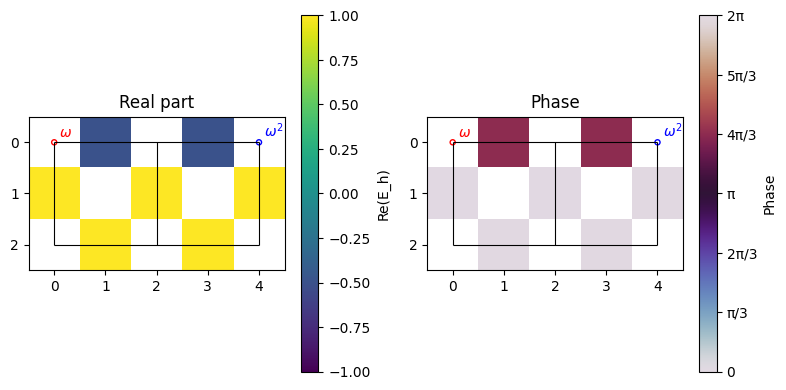

In [155]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(8,4))

# First panel: real part of E_h
im_real = ax[0].imshow(E_h.real, cmap="viridis", vmin=-1, vmax=1)
ax[0].set_title("Real part")
cbar_real = fig.colorbar(im_real, ax=ax[0])
cbar_real.set_label("Re(E_h)")

# Second panel: Z3 phase
im = ax[1].imshow(phase, cmap='twilight', vmin=0, vmax=2*np.pi)
ax[1].set_title("Phase")

# Colorbar
cbar = fig.colorbar(im, ax=ax[1])

# choose tick locations: here every π/3
ticks = np.arange(0, 2*np.pi + 1e-6, np.pi/3)
cbar.set_ticks(ticks)

def pi_formatter(x, pos):
    """Format tick x (in radians) as a multiple of π with nice fractions."""
    n = np.round(x/np.pi*3)   # integers for thirds of π
    # map integer counts of π/3 to string labels
    labels = {
        0: "0",
        1: "π/3",
        2: "2π/3",
        3: "π",
        4: "4π/3",
        5: "5π/3",
        6: "2π"
    }
    return labels.get(int(n), "")

cbar.ax.yaxis.set_major_formatter(FuncFormatter(pi_formatter))
cbar.set_label("Phase")

# create the lattice
hlines = list(range(E_h.shape[0]))[::2]
vlines = list(range(E_h.shape[1]))[::2]
for idx in range(2):
    ax[idx].hlines(y=hlines, xmin=0, xmax=E_h.shape[1] - 1, colors="k", linewidth=0.8)
    ax[idx].vlines(x=vlines, ymin=0, ymax=E_h.shape[0] - 1, colors="k", linewidth=0.8)

    # add charges
    if cx != None:
        for i in range(len(cx)):
            if vals[i] == omega:
                q = "$\omega$"
                color = "red"
            elif vals[i] == omega**2:
                q = "$\omega^2$"
                color = "blue"
                
            ax[idx].text(
                x=2 * cx[i] + 0.1, y=2 * cy[i] - 0.1, s=q, color=color
            )
            circle = Ellipse(
                (2 * cx[i], 2 * cy[i]),
                0.1,
                0.1,
                edgecolor=color,
                facecolor="none",
                linewidth=1,
            )
            ax[idx].add_patch(circle)

plt.tight_layout()
plt.show()

### $3$ charges (as quarks uud or ddu)

In [160]:
Lx = 2
Ly = 2
cx = [0,1,2]
cy = [0,2,0]
pbc = False
vals = [omega, omega, omega]
Z3_baryon = H_Z3_gauss(Lx, Ly, model="Z3", J=1, lamb=0, G=10, pbc=pbc)
print(Z3_baryon.charges, Z3_baryon.latt.sites)
Z3_baryon.add_charges(cx,cy,vals)
print(Z3_baryon.charges)
print(Z3_baryon.latt._lattice_drawer.draw_lattice())

[[1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j]] [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
[[-0.5+0.8660254j  1. +0.j        -0.5+0.8660254j]
 [ 1. +0.j         1. +0.j         1. +0.j       ]
 [ 1. +0.j        -0.5+0.8660254j  1. +0.j       ]]
      +-- 5--+-- 6--+      
      |      |      |      
      10     11     12
      |      |      |      
      +-- 3--+-- 4--+      
      |      |      |      
      7      8      9 
      |      |      |      
      +-- 1--+-- 2--+      



In [161]:
e, v = Z3_baryon.diagonalize()

(0, 0) 1 normal
(0, 0) 7 normal
(0, 1) 3 normal
(0, 1) 10 normal
(0, 1) 7 conjugate
(0, 2) 5 normal
(0, 2) 10 conjugate
(1, 0) 2 normal
(1, 0) 8 normal
(1, 0) 1 conjugate
(1, 1) 4 normal
(1, 1) 11 normal
(1, 1) 3 conjugate
(1, 1) 8 conjugate
(1, 2) 6 normal
(1, 2) 5 conjugate
(1, 2) 11 conjugate
(2, 0) 9 normal
(2, 0) 2 conjugate
(2, 1) 12 normal
(2, 1) 4 conjugate
(2, 1) 9 conjugate
(2, 2) 6 conjugate
(2, 2) 12 conjugate


In [162]:
dof = 2 * Lx * Ly + (Lx * (1 - pbc)) + Ly
loc_mag = []
for site in range(dof):
    loc_mag.append((csr_array(v).conjugate().T @ op_on_sites_sparse(V, N=dof, sites=site) @ csr_array(v)).toarray()[0])

shape_el_field = (2 * Ly + 1*(1 - pbc), 2 * Lx + 1)
E_h = np.zeros(shape_el_field, dtype=np.complex128)
E_h[:] = np.nan
horizontal_links = np.asarray(loc_mag[0:Lx*(Ly + 1*(1 - pbc))]).reshape((Ly + 1*(1 - pbc),Lx))
vertical_links = np.asarray(loc_mag[Lx*(Ly + 1*(1 - pbc))::]).reshape((Ly,Lx+1))
E_h[0::2,1::2] = horizontal_links[::-1]
E_h[1::2,0::2] = vertical_links[::-1]
phase = np.angle(E_h) % (2*np.pi)

print(horizontal_links, vertical_links, phase)

[[ 1. +2.76990947e-30j  1. -1.76357758e-30j]
 [ 1. -6.65216755e-30j  1. +3.20876713e-30j]
 [-0.5-8.66025404e-01j -0.5+8.66025404e-01j]] [[ 1. -2.73721812e-30j -0.5-8.66025404e-01j  1. -1.79857149e-30j]
 [ 1. +4.48612080e-30j -0.5-8.66025404e-01j  1. +1.66928477e-30j]] [[           nan 4.18879020e+00            nan 2.09439510e+00
             nan]
 [4.48612080e-30            nan 4.18879020e+00            nan
  1.66928477e-30]
 [           nan 6.28318531e+00            nan 3.20876713e-30
             nan]
 [6.28318531e+00            nan 4.18879020e+00            nan
  6.28318531e+00]
 [           nan 2.76990947e-30            nan 6.28318531e+00
             nan]]


<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\o'
C:\Users\HP\AppData\Local\Temp\ipykernel_460\3343861990.py:53: SyntaxWarning: invalid escape sequence '\o'
  q = "$\omega$"
C:\Users\HP\AppData\Local\Temp\ipykernel_460\3343861990.py:56: SyntaxWarning: invalid escape sequence '\o'
  q = "$\omega^2$"


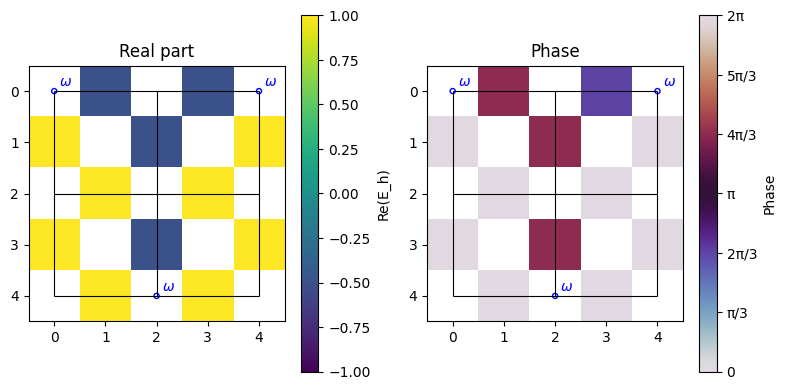

In [163]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(8,4))

# First panel: real part of E_h
im_real = ax[0].imshow(E_h.real, cmap="viridis", vmin=-1, vmax=1)
ax[0].set_title("Real part")
cbar_real = fig.colorbar(im_real, ax=ax[0])
cbar_real.set_label("Re(E_h)")

# Second panel: Z3 phase
im = ax[1].imshow(phase, cmap='twilight', vmin=0, vmax=2*np.pi)
ax[1].set_title("Phase")

# Colorbar
cbar = fig.colorbar(im, ax=ax[1])

# choose tick locations: here every π/3
ticks = np.arange(0, 2*np.pi + 1e-6, np.pi/3)
cbar.set_ticks(ticks)

def pi_formatter(x, pos):
    """Format tick x (in radians) as a multiple of π with nice fractions."""
    n = np.round(x/np.pi*3)   # integers for thirds of π
    # map integer counts of π/3 to string labels
    labels = {
        0: "0",
        1: "π/3",
        2: "2π/3",
        3: "π",
        4: "4π/3",
        5: "5π/3",
        6: "2π"
    }
    return labels.get(int(n), "")

cbar.ax.yaxis.set_major_formatter(FuncFormatter(pi_formatter))
cbar.set_label("Phase")

# create the lattice
hlines = list(range(E_h.shape[0]))[::2]
vlines = list(range(E_h.shape[1]))[::2]
for idx in range(2):
    ax[idx].hlines(y=hlines, xmin=0, xmax=E_h.shape[1] - 1, colors="k", linewidth=0.8)
    ax[idx].vlines(x=vlines, ymin=0, ymax=E_h.shape[0] - 1, colors="k", linewidth=0.8)

    # add charges
    if cx != None:
        for i in range(len(cx)):
            if vals[i] == omega:
                q = "$\omega$"
                color = "blue"
            elif vals[i] == omega**2:
                q = "$\omega^2$"
                color = "red"
                
            ax[idx].text(
                x=2 * cx[i] + 0.1, y=2 * cy[i] - 0.1, s=q, color=color
            )
            circle = Ellipse(
                (2 * cx[i], 2 * cy[i]),
                0.1,
                0.1,
                edgecolor=color,
                facecolor="none",
                linewidth=1,
            )
            ax[idx].add_patch(circle)

plt.tight_layout()
plt.show()

## Duality